Do some common imports:

In [1]:
import ipdb
import json
import os
import glob
import numpy as np
import pandas as pd
import scipy.io
from collections import defaultdict
import ipdb
from itertools import chain
import tensorflow as tf
import tensorflow_hub as hub
import tqdm
import seaborn as sns
import nltk

Define text normalization functions (part-of-speech tagging, tokenization and lemmatization):

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


nltk.download('wordnet') # download wordnet
nltk.download('averaged_perceptron_tagger') # download pos tagger

wordnet_lemmatizer = WordNetLemmatizer() #initialize wordnet_lemmatizer class

# Function to convert tag from Treebank format to Wornet format
def get_wordnet_pos(tag):    
    if tag[0] == 'J': return wordnet.ADJ
    elif tag[0] == 'V': return wordnet.VERB
    elif tag[0] == 'N': return wordnet.NOUN
    elif tag[0] == 'R': return wordnet.ADV
    else: return wordnet.NOUN

# Function to lemmatize a list of tokens
def lemmatize(tokens):   
    tagged_tokens = pos_tag(tokens) # tag tokens with part-of-speech
    
    lemmatized_tokens = []  
    
    for tagged_token in tagged_tokens:        
        token, tag = tagged_token[0], tagged_token[1]
        wordnet_pos = get_wordnet_pos(tag[1]) # convert tag to wordnet format
        lem_token = wordnet_lemmatizer.lemmatize(tag[0], pos=wordnet_pos) # lemmatize
        lemmatized_tokens.append(lem_token) # append to list

    return lemmatized_tokens

# Function to tokenize sentence (and lemmatize if specified)
def normalize(sentence, lemmatize=False):
    tokens = word_tokenize(sentence)
    if lemmatize: tokens = lemmatize(tokens)
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /afs/csail.mit.edu/u/m/mireiahernandez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /afs/csail.mit.edu/u/m/mireiahernandez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Define a function to embed sentences using the Universal Sentence Encoder, and a function to calculate the angular similarity matrix between two lists of embeddings:

In [3]:
import tensorflow_hub as hub
import tensorflow as tf

# Load USE tensorflow_hub module
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

# Function to encode a list of sentences using USE
def get_USE_embeddings(sentences):
    with tf.compat.v1.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = session.run(embed(sentences))
    return embeddings

# Function to calculate angular similarity between two lists of embeddings
def get_angular_similarity_matrix(list1, list2):
    embed1 = get_USE_embeddings(list1)
    embed2 = get_USE_embeddings(list2)
    cosine = np.inner(embed1, embed2)
    cosine = np.minimum(cosine, np.ones(shape=cosine.shape))
    distance = np.arccos(cosine)/np.pi
    angular_sim  = 1 - distance
    return angular_sim  

Define a function to obtain the Jaccard similarity scores between two lists of tokens, and the similarity matrix betweenn two lists of lists of tokens:

In [4]:
def get_jaccard_similarity_score(tokens1, tokens2):
    # Convert tokenss to sets
    set1, set2 = set(tokens1), set(tokens2)
    
    # Compute set intersection
    set_intersect = set1.intersection(set2)
    
    # Calculate intersection and union length
    intersect_len  = len(set_intersect)    
    union_len = len(set1) + len(set2) - intersect_len
    
    # Calculate jaccard similarity score
    jaccard = float(intersect_len) / float(union_len)
    return jaccard

def get_jaccard_similarity_matrix(list1, list2):
    len1, len2 = len(list1), len(list2)
    jaccard_matrix = np.zeros(shape=(len1,len2))
    for i in tqdm.tqdm(range(len1)):
        for j in range(len2):
            jaccard_matrix[i, j] = get_jaccard_similarity_score(list1[i], list2[j])
    return jaccard_matrix

Define function to clean subtitle lines (they have a weird format):

In [ ]:
def clean(line):
    return line[0][1:].replace('<i>', '').replace('...',' ').replace('</i>', '')

Define a function to get subtitle sentences from movie:

In [5]:
def get_srt(movie):
    # Load subtitles
    srt = scipy.io.loadmat('{}srts/{}.mat'.format(bksnmvs_path, movie))

    # Get subtitle lines (remove initial space)
    srt_lines = [sent[0][1:].replace('<i>', '').replace('</i>', '') for sent in srt['srt']['content'][0]]


    # Join lines to one string and remove '<i>' and '...'
    srt_joint_lines = ' '.join(srt_lines)

    # Split sentences correctly
    srt_sentences = nltk.sent_tokenize(srt_joint_lines)
    
    # Get dictionary from line num to sent num
    line_char_sum = np.cumsum([len(line)+1 for line in srt_lines])
    sent_char_sum = np.cumsum([len(sent)+1 for sent in srt_sentences])
    num_lines = len(srt_lines)
    num_sents = len(srt_sentences)
    
    line_to_sent = defaultdict(list)
    for sent_num, sent in enumerate(srt_sentences):
        sent_init = sent_char_sum[sent_num-1] if sent_num > 0 else 0
        sent_end = sent_char_sum[sent_num]
        sent_set = set(range(sent_init, sent_end))
        for num in range(num_lines):
            line_init = line_char_sum[num-1] if num > 0 else 0
            line_end = line_char_sum[num]
            line_set = set(range(line_init, line_end))
            if len(sent_set.intersection(line_set)) > 0:
                line_to_sent[num].append(sent_num)


    return srt_sentences, line_to_sent

Define a function to get book sentences and dialogs:

In [6]:
def get_book(movie):
    # Load book
    book_name = getBookName(movie)
    book_file = scipy.io.loadmat(book_name)
    
    # Get sentences
    book_sentences = book_file['book']['sentences'].item()['sentence']
    book_sentences = [sent[0][0] for sent in book_sentences]
    num_sents = len(book_sentences)
    
    # Get dialog probabilities
    dialog_probs = np.array([raw_labeled_sents[movie][str(idx)][0] for idx in range(num_sents)])
    dialog_window = 5
    
    # Filter dialogs
    book_dialogs = []
    dial_to_sent = {}
    dial_num = 0
    for id_sent, sent in enumerate(book_sentences):
        is_dialog = dialog_probs[id_sent] > 0.5
        if is_dialog:
            book_dialogs.append(sent)
            dial_to_sent[dial_num] = id_sent
            dial_num += 1
    
    return book_sentences, book_dialogs, dial_to_sent

Define a function to get ground truth dialog alignments:

In [7]:
def get_gt_align(movie):
    # Get annotations
    file_anno = anno_path + movie + '-anno.mat'
    anno_file = scipy.io.loadmat(file_anno)
    annotation = anno_file['anno']
    num_align = annotation.shape[1]

    gt_alignments = []
    for i in range(num_align):
        if movie != 'The.Road' or i != 127: # missing data
            # if alignment id dialog
            if annotation['D'][0][i].item() == 1:
                id_sent = annotation['sentence'][0][i].item()-1
                id_srt = annotation['srt'][0][i].item()-1  
                gt_alignments.append([id_sent, id_srt])
    return gt_alignments

Define a function to get the book name on the server:

In [8]:
def getBookName(filen):
    filen.split('/')[-1]
    book_path = '{}/books/'.format(bksnmvs_path)
    book_name = filen+'.(hl-2).mat'
    return book_path+book_name


Define a function to compute recall given a similarity matrix, a list of ground-truth alignments of subtitle line to book sentence, and a dictionary that maps subtitle line numbers to subtitle sentences and the window that we take due to noisy alignments:

In [1]:
def compute_recall(sim_matrix, gt_alignments, line_to_sent, window=10):
    r1, r5, r10 = 0, 0, 0
    total_gt = len(gt_alignments)
    for alignment in gt_alignments:
        book_id, srt_line_id = alignment[0], alignment[1]
        srt_ids = line_to_sent[srt_line_id]
        
        # Recall from srt to book
        recalled1, recalled5, recalled10 = False,False,False
        for srt_id in srt_ids:
            book_id_sorted = np.argsort(sim_matrix[:,srt_id])[::-1]           
           
            # Recall at 1
            if abs(book_id - book_id_sorted[0]) < window:
                recalled1 = True
     
            # Recall at 5
            for book_idx in book_id_sorted[:5]:
                if abs(book_id - book_idx) < window: recalled5 = True
            
            # Recall at 10
            for book_idx in book_id_sorted[:10]:
                if abs(book_id - book_idx) < window: recalled10 = True
        if recalled1: r1 += 1
        if recalled5: r5 += 1
        if recalled10: r10 += 1
            
    return [r1/total_gt, r5/total_gt, r10/total_gt]

Define a function that computes the recall only over filtered dialogs in the book:

In [10]:
def compute_recall_filtered(sim_matrix, gt_alignments, line_to_sent, dial_to_sent, window=10):
    r1, r5, r10 = 0, 0, 0
    total_gt = len(gt_alignments)
    for alignment in gt_alignments:
        book_id, srt_line_id = alignment[0], alignment[1]
        srt_ids = line_to_sent[srt_line_id]
        recalled1, recalled5, recalled10 = False,False,False
        for srt_id in srt_ids:
            book_dial_sorted = np.argsort(sim_matrix[:,srt_id])[::-1]           
            book_id_sorted = [dial_to_sent[dial] for dial in book_dial_sorted]
            
            # Recall at 1
            if abs(book_id - book_id_sorted[0]) < window: recalled1 = True
     
            # Recall at 5
            for book_idx in book_id_sorted[:5]:
                if abs(book_id - book_idx) < window: recalled5 = True
            
            # Recall at 10
            for book_idx in book_id_sorted[:10]:
                if abs(book_id - book_idx) < window: recalled10 = True
        if recalled1: r1 += 1
        if recalled5: r5 += 1
        if recalled10: r10 += 1
            
    return [r1/total_gt, r5/total_gt, r10/total_gt]

Define paths on the server:

In [11]:
dataset_path = '/data/vision/torralba/datasets/movies/data/'
bksnmvs_path = '/data/vision/torralba/frames/data_acquisition/booksmovies/data/booksandmovies/'
anno_path = '{}/antonio/annotation/'.format(bksnmvs_path)
text_annotation_path = '/data/vision/torralba/movies-books/booksandmovies/joanna/bksnmovies/data/gt_alignment/consecutive_text_labels_v2'
cootmil_path = '/data/vision/torralba/scratch/mireiahe/COOT-MIL/'
coot_path = '/data/vision/torralba/scratch/mireiahe/coot-videotext/'
dialog_anno = json.load(open(cootmil_path + 'data/bksnmovies/dialog_anno.json', 'r'))
labeled_sents = json.load(open('labeled_sents.json', 'r'))
raw_labeled_sents = json.load(open('raw_labeled_sents.json', 'r'))
movies = ['American.Psycho','Brokeback.Mountain','Fight.Club','Gone.Girl','Harry.Potter.and.the.Sorcerers.Stone','No.Country.for.Old.Men','One.Flew.Over.the.Cuckoo.Nest','Shawshank.Redemption','The.Firm','The.Green.Mile','The.Road']
movies_titles = [movie.replace('.', '_') for movie in movies]
imbds = ['tt0144084','tt0388795','tt0137523','tt2267998','tt0241527','tt0477348','tt0073486','tt0111161','tt0106918','tt0120689','tt0898367']
dataset_split = 1  # 1 for 90% data from all movies in train and 10% in val; 2 for n-1 movies in train 1 in val
val_movie = movies[-1]

Compute recall for all movies:

In [15]:
results = {}

for i, movie in enumerate(movies):
    print(f"Movie: {movie}")
    print("Getting srt and book sentences...")
    srt_sentences, line_to_sent = get_srt(movie)
    book_sentences, book_dialogs, dial_to_sent =  get_book(movie)
    gt_alignments = get_gt_align(movie)
    
    print('Normalizing...')
    norm_book_sentences = [normalize(sent) for sent in book_sentences]
    norm_srt_sentences = [normalize(sent) for sent in srt_sentences]
    
    print("Getting jaccard ...")
    jaccard_matrix = get_jaccard_similarity_matrix(norm_book_sentences, norm_srt_sentences)
    print("Getting angular ...")
    angular_matrix = get_angular_similarity_matrix(book_sentences, srt_sentences)
    mean_matrix1 = 0.5*(jaccard_matrix + angular_matrix)
    mean_matrix2 = 0.6*jaccard_matrix + 0.4*angular_matrix
    
    print("Getting jaccard filtered...")
    jaccard_matrix_filtered = jaccard_matrix[[sent for dial, sent in dial_to_sent.items()],:]
    print("Getting angular filtered...")
    angular_matrix_filtered = angular_matrix[[sent for dial, sent in dial_to_sent.items()],:]
    mean_matrix_filtered = 0.5*(jaccard_matrix_filtered + angular_matrix_filtered)
    
    print("Computing recall...")
    jaccard_recall = compute_recall(jaccard_matrix, gt_alignments, line_to_sent, window=9)
    angular_recall = compute_recall(angular_matrix, gt_alignments, line_to_sent, window=9)
    mean_recall1 = compute_recall(mean_matrix1, gt_alignments, line_to_sent, window=9)
    mean_recall2 = compute_recall(mean_matrix2, gt_alignments, line_to_sent, window=9)
    results[movie] = {'recall/jaccard':jaccard_recall, 'recall/angular':angular_recall, 'recall/mean1':mean_recall1, 'recall/mean2':mean_recall2}
    
    if len(book_dialogs) > 0:
        jaccard_recall_filtered = compute_recall_filtered(jaccard_matrix_filtered, gt_alignments, line_to_sent, dial_to_sent, window=10)
        angular_recall_filtered = compute_recall_filtered(angular_matrix_filtered, gt_alignments, line_to_sent, dial_to_sent, window=10)
        mean_recall_filtered = compute_recall_filtered(mean_matrix_filtered, gt_alignments, line_to_sent, dial_to_sent, window=10)
        results[movie]['recall/jaccard_filtered'] = jaccard_recall_filtered
        results[movie]['recall/angular_filtered'] = angular_recall_filtered
        results[movie]['recall/mean_filtered'] = mean_recall_filtered
        print(results[movie])
    
    print(results[movie])

Movie: American.Psycho
Getting srt and book sentences...
Normalizing...


  0%|          | 16/11304 [00:00<01:10, 159.25it/s]

Getting jaccard ...


100%|██████████| 11304/11304 [00:41<00:00, 275.40it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.7077464788732394, 0.8028169014084507, 0.8274647887323944], 'recall/angular': [0.704225352112676, 0.778169014084507, 0.8204225352112676], 'recall/mean1': [0.7570422535211268, 0.8450704225352113, 0.8661971830985915], 'recall/mean2': [0.7535211267605634, 0.8345070422535211, 0.8626760563380281], 'recall/jaccard_filtered': [0.7007042253521126, 0.7676056338028169, 0.7852112676056338], 'recall/angular_filtered': [0.6373239436619719, 0.7183098591549296, 0.7464788732394366], 'recall/mean_filtered': [0.7288732394366197, 0.7852112676056338, 0.8063380281690141]}
{'recall/jaccard': [0.7077464788732394, 0.8028169014084507, 0.8274647887323944], 'recall/angular': [0.704225352112676, 0.778169014084507, 0.8204225352112676], 'recall/mean1': [0.7570422535211268, 0.8450704225352113, 0.8661971830985915], 'recall/mean2': [0.7535211267605634, 0.8345070422535211, 0.8626760563380281], 'recall/jaccard_filtered': [0.

  5%|▍         | 30/638 [00:00<00:02, 295.99it/s]

Getting jaccard ...


100%|██████████| 638/638 [00:01<00:00, 326.47it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.5375, 0.6375, 0.7125], 'recall/angular': [0.5625, 0.7, 0.7375], 'recall/mean1': [0.625, 0.7125, 0.7625], 'recall/mean2': [0.6125, 0.7125, 0.7375], 'recall/jaccard_filtered': [0.375, 0.5125, 0.5625], 'recall/angular_filtered': [0.3875, 0.4875, 0.525], 'recall/mean_filtered': [0.45, 0.5125, 0.55]}
{'recall/jaccard': [0.5375, 0.6375, 0.7125], 'recall/angular': [0.5625, 0.7, 0.7375], 'recall/mean1': [0.625, 0.7125, 0.7625], 'recall/mean2': [0.6125, 0.7125, 0.7375], 'recall/jaccard_filtered': [0.375, 0.5125, 0.5625], 'recall/angular_filtered': [0.3875, 0.4875, 0.525], 'recall/mean_filtered': [0.45, 0.5125, 0.55]}
Movie: Fight.Club
Getting srt and book sentences...
Normalizing...


  0%|          | 18/4229 [00:00<00:23, 175.73it/s]

Getting jaccard ...


100%|██████████| 4229/4229 [00:23<00:00, 178.69it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.052941176470588235, 0.07058823529411765, 0.13529411764705881], 'recall/angular': [0.047058823529411764, 0.08235294117647059, 0.11176470588235295], 'recall/mean1': [0.058823529411764705, 0.08823529411764706, 0.14705882352941177], 'recall/mean2': [0.06470588235294118, 0.08235294117647059, 0.12352941176470589], 'recall/jaccard_filtered': [0.0, 0.011764705882352941, 0.03529411764705882], 'recall/angular_filtered': [0.0, 0.023529411764705882, 0.06470588235294118], 'recall/mean_filtered': [0.0, 0.041176470588235294, 0.058823529411764705]}
{'recall/jaccard': [0.052941176470588235, 0.07058823529411765, 0.13529411764705881], 'recall/angular': [0.047058823529411764, 0.08235294117647059, 0.11176470588235295], 'recall/mean1': [0.058823529411764705, 0.08823529411764706, 0.14705882352941177], 'recall/mean2': [0.06470588235294118, 0.08235294117647059, 0.12352941176470589], 'recall/jaccard_filtered': [0.0

  0%|          | 17/12609 [00:00<01:14, 167.95it/s]

Getting jaccard ...


100%|██████████| 12609/12609 [01:18<00:00, 159.87it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.34210526315789475, 0.4342105263157895, 0.4868421052631579], 'recall/angular': [0.32894736842105265, 0.4342105263157895, 0.5], 'recall/mean1': [0.3815789473684211, 0.4605263157894737, 0.5], 'recall/mean2': [0.3684210526315789, 0.4605263157894737, 0.5], 'recall/jaccard_filtered': [0.14473684210526316, 0.19736842105263158, 0.2631578947368421], 'recall/angular_filtered': [0.14473684210526316, 0.2236842105263158, 0.27631578947368424], 'recall/mean_filtered': [0.19736842105263158, 0.2631578947368421, 0.27631578947368424]}
{'recall/jaccard': [0.34210526315789475, 0.4342105263157895, 0.4868421052631579], 'recall/angular': [0.32894736842105265, 0.4342105263157895, 0.5], 'recall/mean1': [0.3815789473684211, 0.4605263157894737, 0.5], 'recall/mean2': [0.3684210526315789, 0.4605263157894737, 0.5], 'recall/jaccard_filtered': [0.14473684210526316, 0.19736842105263158, 0.2631578947368421], 'recall/angular

  0%|          | 25/6458 [00:00<00:25, 249.30it/s]

Getting jaccard ...


100%|██████████| 6458/6458 [00:23<00:00, 270.95it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.6463414634146342, 0.7378048780487805, 0.7865853658536586], 'recall/angular': [0.5853658536585366, 0.7012195121951219, 0.7621951219512195], 'recall/mean1': [0.7012195121951219, 0.7865853658536586, 0.8292682926829268], 'recall/mean2': [0.7134146341463414, 0.7987804878048781, 0.8170731707317073], 'recall/jaccard_filtered': [0.5853658536585366, 0.6707317073170732, 0.7073170731707317], 'recall/angular_filtered': [0.5670731707317073, 0.6951219512195121, 0.7439024390243902], 'recall/mean_filtered': [0.6402439024390244, 0.75, 0.7682926829268293]}
{'recall/jaccard': [0.6463414634146342, 0.7378048780487805, 0.7865853658536586], 'recall/angular': [0.5853658536585366, 0.7012195121951219, 0.7621951219512195], 'recall/mean1': [0.7012195121951219, 0.7865853658536586, 0.8292682926829268], 'recall/mean2': [0.7134146341463414, 0.7987804878048781, 0.8170731707317073], 'recall/jaccard_filtered': [0.5853658536

  0%|          | 38/8050 [00:00<00:21, 378.80it/s]

Getting jaccard ...


100%|██████████| 8050/8050 [00:20<00:00, 388.49it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.8251121076233184, 0.8609865470852018, 0.8878923766816144], 'recall/angular': [0.7937219730941704, 0.8654708520179372, 0.8834080717488789], 'recall/mean1': [0.8340807174887892, 0.8834080717488789, 0.905829596412556], 'recall/mean2': [0.8295964125560538, 0.8834080717488789, 0.9013452914798207], 'recall/jaccard_filtered': [0.008968609865470852, 0.02242152466367713, 0.053811659192825115], 'recall/angular_filtered': [0.013452914798206279, 0.04932735426008968, 0.06726457399103139], 'recall/mean_filtered': [0.008968609865470852, 0.03587443946188341, 0.04932735426008968]}
{'recall/jaccard': [0.8251121076233184, 0.8609865470852018, 0.8878923766816144], 'recall/angular': [0.7937219730941704, 0.8654708520179372, 0.8834080717488789], 'recall/mean1': [0.8340807174887892, 0.8834080717488789, 0.905829596412556], 'recall/mean2': [0.8295964125560538, 0.8834080717488789, 0.9013452914798207], 'recall/jaccard

  0%|          | 20/7103 [00:00<00:36, 195.72it/s]

Getting jaccard ...


100%|██████████| 7103/7103 [00:38<00:00, 186.30it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.44, 0.5866666666666667, 0.6533333333333333], 'recall/angular': [0.48, 0.6133333333333333, 0.68], 'recall/mean1': [0.52, 0.6933333333333334, 0.7466666666666667], 'recall/mean2': [0.5333333333333333, 0.68, 0.7333333333333333], 'recall/jaccard_filtered': [0.36, 0.4666666666666667, 0.5333333333333333], 'recall/angular_filtered': [0.37333333333333335, 0.5333333333333333, 0.5733333333333334], 'recall/mean_filtered': [0.41333333333333333, 0.5866666666666667, 0.6]}
{'recall/jaccard': [0.44, 0.5866666666666667, 0.6533333333333333], 'recall/angular': [0.48, 0.6133333333333333, 0.68], 'recall/mean1': [0.52, 0.6933333333333334, 0.7466666666666667], 'recall/mean2': [0.5333333333333333, 0.68, 0.7333333333333333], 'recall/jaccard_filtered': [0.36, 0.4666666666666667, 0.5333333333333333], 'recall/angular_filtered': [0.37333333333333335, 0.5333333333333333, 0.5733333333333334], 'recall/mean_filtered': [0.4

  1%|          | 20/2562 [00:00<00:12, 197.01it/s]

Getting jaccard ...


100%|██████████| 2562/2562 [00:12<00:00, 211.65it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.7045454545454546, 0.7727272727272727, 0.7954545454545454], 'recall/angular': [0.5909090909090909, 0.7727272727272727, 0.7954545454545454], 'recall/mean1': [0.7272727272727273, 0.7954545454545454, 0.8181818181818182], 'recall/mean2': [0.7272727272727273, 0.7954545454545454, 0.7954545454545454], 'recall/jaccard_filtered': [0.4090909090909091, 0.5, 0.5454545454545454], 'recall/angular_filtered': [0.38636363636363635, 0.5, 0.5454545454545454], 'recall/mean_filtered': [0.4318181818181818, 0.5681818181818182, 0.5909090909090909]}
{'recall/jaccard': [0.7045454545454546, 0.7727272727272727, 0.7954545454545454], 'recall/angular': [0.5909090909090909, 0.7727272727272727, 0.7954545454545454], 'recall/mean1': [0.7272727272727273, 0.7954545454545454, 0.8181818181818182], 'recall/mean2': [0.7272727272727273, 0.7954545454545454, 0.7954545454545454], 'recall/jaccard_filtered': [0.4090909090909091, 0.5, 0.

  0%|          | 20/15513 [00:00<01:20, 192.38it/s]

Getting jaccard ...


100%|██████████| 15513/15513 [01:15<00:00, 205.54it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.27058823529411763, 0.38823529411764707, 0.4588235294117647], 'recall/angular': [0.4117647058823529, 0.5529411764705883, 0.6], 'recall/mean1': [0.35294117647058826, 0.5411764705882353, 0.6588235294117647], 'recall/mean2': [0.3058823529411765, 0.5058823529411764, 0.611764705882353], 'recall/jaccard_filtered': [0.18823529411764706, 0.25882352941176473, 0.3058823529411765], 'recall/angular_filtered': [0.29411764705882354, 0.36470588235294116, 0.3764705882352941], 'recall/mean_filtered': [0.23529411764705882, 0.32941176470588235, 0.4]}
{'recall/jaccard': [0.27058823529411763, 0.38823529411764707, 0.4588235294117647], 'recall/angular': [0.4117647058823529, 0.5529411764705883, 0.6], 'recall/mean1': [0.35294117647058826, 0.5411764705882353, 0.6588235294117647], 'recall/mean2': [0.3058823529411765, 0.5058823529411764, 0.611764705882353], 'recall/jaccard_filtered': [0.18823529411764706, 0.2588235294

  0%|          | 19/9469 [00:00<00:51, 183.21it/s]

Getting jaccard ...


100%|██████████| 9469/9469 [00:48<00:00, 195.10it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.5528846153846154, 0.6730769230769231, 0.7307692307692307], 'recall/angular': [0.5384615384615384, 0.6634615384615384, 0.6826923076923077], 'recall/mean1': [0.6009615384615384, 0.7259615384615384, 0.7836538461538461], 'recall/mean2': [0.6009615384615384, 0.7307692307692307, 0.7740384615384616], 'recall/jaccard_filtered': [0.5144230769230769, 0.6682692307692307, 0.6971153846153846], 'recall/angular_filtered': [0.49038461538461536, 0.6153846153846154, 0.6586538461538461], 'recall/mean_filtered': [0.5817307692307693, 0.7115384615384616, 0.7692307692307693]}
{'recall/jaccard': [0.5528846153846154, 0.6730769230769231, 0.7307692307692307], 'recall/angular': [0.5384615384615384, 0.6634615384615384, 0.6826923076923077], 'recall/mean1': [0.6009615384615384, 0.7259615384615384, 0.7836538461538461], 'recall/mean2': [0.6009615384615384, 0.7307692307692307, 0.7740384615384616], 'recall/jaccard_filtered'

  1%|          | 49/6638 [00:00<00:13, 489.70it/s]

Getting jaccard ...


100%|██████████| 6638/6638 [00:12<00:00, 520.70it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...
Computing recall...
{'recall/jaccard': [0.6111111111111112, 0.7698412698412699, 0.8174603174603174], 'recall/angular': [0.7142857142857143, 0.8333333333333334, 0.8333333333333334], 'recall/mean1': [0.7380952380952381, 0.8333333333333334, 0.873015873015873], 'recall/mean2': [0.7380952380952381, 0.8174603174603174, 0.8492063492063492], 'recall/jaccard_filtered': [0.023809523809523808, 0.047619047619047616, 0.07142857142857142], 'recall/angular_filtered': [0.031746031746031744, 0.06349206349206349, 0.07936507936507936], 'recall/mean_filtered': [0.023809523809523808, 0.06349206349206349, 0.07142857142857142]}
{'recall/jaccard': [0.6111111111111112, 0.7698412698412699, 0.8174603174603174], 'recall/angular': [0.7142857142857143, 0.8333333333333334, 0.8333333333333334], 'recall/mean1': [0.7380952380952381, 0.8333333333333334, 0.873015873015873], 'recall/mean2': [0.7380952380952381, 0.8174603174603174, 0.8492063492063492], 'recall/jaccard

Get statistics of number of dialogues and sentences in the book, as well as sentence and lines in the subtitles, and number of tokens:

In [12]:
statistics = {}

for i, movie in enumerate(movies):
    print(f"Movie: {movie}")
    print("Getting srt and book sentences...")
    srt_sentences, line_to_sent = get_srt(movie)
    book_sentences, book_dialogs, dial_to_sent =  get_book(movie)
    gt_alignments = get_gt_align(movie)
    
    print('Normalizing...')
    norm_book_sentences = [normalize(sent) for sent in book_sentences]
    norm_srt_sentences = [normalize(sent) for sent in srt_sentences]
    statistics[movie]= {
        'book/sent_num': len(book_sentences),
        'book/dial_num': len(book_dialogs),
        'srt/sent_num': len(srt_sentences),
        'srt/line_num': len(list(line_to_sent.keys())),
        'book/avg_token_num': np.mean([len(tokenlist) for tokenlist in norm_book_sentences]),
        'srt/avg_token_num': np.mean([len(tokenlist) for tokenlist in norm_srt_sentences]),
        'num_alignments': len(gt_alignments)
        
    }
json.dump(statistics, open('statistics.json', 'w'))
    

Movie: American.Psycho
Getting srt and book sentences...
Normalizing...
Movie: Brokeback.Mountain
Getting srt and book sentences...
Normalizing...
Movie: Fight.Club
Getting srt and book sentences...
Normalizing...
Movie: Gone.Girl
Getting srt and book sentences...
Normalizing...
Movie: Harry.Potter.and.the.Sorcerers.Stone
Getting srt and book sentences...
Normalizing...
Movie: No.Country.for.Old.Men
Getting srt and book sentences...
Normalizing...
Movie: One.Flew.Over.the.Cuckoo.Nest
Getting srt and book sentences...
Normalizing...
Movie: Shawshank.Redemption
Getting srt and book sentences...
Normalizing...
Movie: The.Firm
Getting srt and book sentences...
Normalizing...
Movie: The.Green.Mile
Getting srt and book sentences...
Normalizing...
Movie: The.Road
Getting srt and book sentences...
Normalizing...


Print statistics to put in the thesis:

In [20]:
for key in statistics.keys():
    stats = statistics[key]
    print(f"{key}: {stats['book/sent_num']} & {stats['book/dial_num']} & {stats['book/avg_token_num']} & {stats['srt/line_num']} & {stats['book/sent_num']} & {stats['srt/avg_token_num']}")

American.Psycho: 11304 & 10371 & 16.480626326963908 & 1311 & 11304 & 8.583276216586704
Brokeback.Mountain: 638 & 554 & 19.885579937304076 & 1228 & 638 & 8.404861693210394
Fight.Club: 4229 & 2439 & 14.031213052731141 & 1864 & 4229 & 7.539729501267963
Gone.Girl: 12609 & 9973 & 14.45610278372591 & 2555 & 12609 & 7.610837438423645
Harry.Potter.and.the.Sorcerers.Stone: 6458 & 6035 & 15.319758439145247 & 1227 & 6458 & 7.249841068022886
No.Country.for.Old.Men: 8050 & 460 & 9.954037267080745 & 889 & 8050 & 7.93071000855432
One.Flew.Over.the.Cuckoo.Nest: 7103 & 5836 & 18.94227791074194 & 1553 & 7103 & 7.123231401186673
Shawshank.Redemption: 2562 & 1328 & 18.39071038251366 & 1879 & 2562 & 8.578158458244111
The.Firm: 15513 & 12502 & 11.04106233481596 & 1775 & 15513 & 7.563186813186813
The.Green.Mile: 9469 & 7795 & 17.131164853733235 & 1846 & 9469 & 7.41447053186392
The.Road: 6638 & 223 & 10.202470623681831 & 782 & 6638 & 5.923076923076923


In [17]:
json.dump(results, open('results_dial_nowind_recall_wind9.json', 'w'))

In [17]:
mean1 = []
for key in results.keys():
    if key not in ['Fight.Club','Gone.Girl', 'One.Flew.Over.the.Cukoo.Nest', 'The.Firm']:
        mean1.append(results[key]['recall/jaccard_filtered'][0])
np.mean(mean1)

0.4532669692898026

Tests with single pairs:

In [34]:
i = 0
movie = movies[i]
print(f"Movie: {movie}")
print("Getting srt and book sentences...")
srt_sentences, line_to_sent = get_srt(movie)
book_sentences, book_dialogs, dial_to_sent =  get_book(movie)
gt_alignments = get_gt_align(movie)

print('Normalizing...')
norm_book_sentences = [normalize(sent) for sent in book_sentences]
norm_srt_sentences = [normalize(sent) for sent in srt_sentences]

print("Getting jaccard ...")
jaccard_matrix = get_jaccard_similarity_matrix(norm_book_sentences, norm_srt_sentences)
print("Getting angular ...")
angular_matrix = get_angular_similarity_matrix(book_sentences, srt_sentences)
mean_matrix = 0.5*(jaccard_matrix + angular_matrix)

print("Getting jaccard filtered...")
jaccard_matrix_filtered = jaccard_matrix[[sent for dial, sent in dial_to_sent.items()],:]
print("Getting angular filtered...")
angular_matrix_filtered = angular_matrix[[sent for dial, sent in dial_to_sent.items()],:]
mean_matrix_filtered = 0.5*(jaccard_matrix_filtered + angular_matrix_filtered)



Movie: American.Psycho
Getting srt and book sentences...
Normalizing...


  0%|          | 28/11304 [00:00<00:41, 272.99it/s]

Getting jaccard ...


100%|██████████| 11304/11304 [00:42<00:00, 264.79it/s]


Getting angular ...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Getting jaccard filtered...
Getting angular filtered...


In [13]:
print("Computing recall...")
jaccard_recall = compute_recall(jaccard_matrix, gt_alignments, line_to_sent, window=9)
angular_recall = compute_recall(an
                                gular_matrix, gt_alignments, line_to_sent, window=9)
mean_recall = compute_recall(mean_matrix, gt_alignments, line_to_sent, window=9)

Computing recall...


In [35]:
import seaborn as sb
import matplotlib.pyplot as plt

In [36]:
num_align = len(gt_alignments)
jacc = np.zeros(shape=(num_align,num_align))
ang = np.zeros(shape=(num_align,num_align))
mean = np.zeros(shape=(num_align,num_align))

for i in range(num_align):
    book_id = gt_alignments[i][0]
    for j in range(num_align):
        srt_line_id = gt_alignments[j][1]
        srt_ids = line_to_sent[srt_line_id]
        jacc[i, j] = np.max(jaccard_matrix[book_id:book_id+1, srt_ids])
        ang[i,j] = np.max(angular_matrix[book_id:book_id+1, srt_ids])
        mean[i,j] = np.max(mean_matrix[book_id:book_id+1, srt_ids])

Text(721.8235294117648, 0.5, 'book sent.')

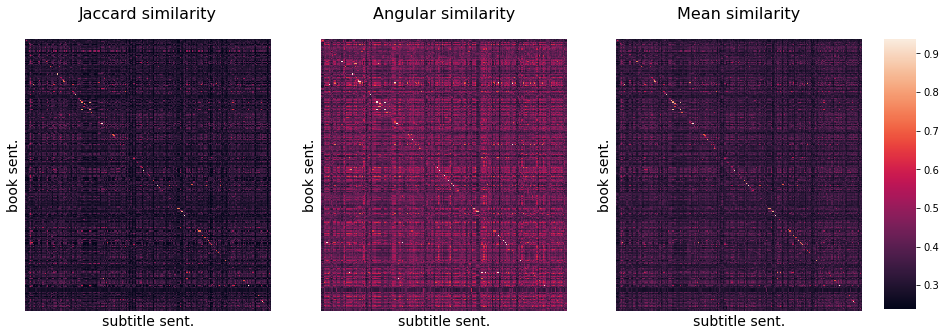

In [37]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
cbar_ax = fig.add_axes([0.92, .13, .03, .75])
sb.heatmap(jacc, ax=axs[0], xticklabels=False, yticklabels=False, cbar=False)
sb.heatmap(ang, ax=axs[1], xticklabels=False, yticklabels=False, cbar=False)
sb.heatmap(mean, ax=axs[2], xticklabels=False, yticklabels=False, cbar=True, cbar_ax = cbar_ax)
axs[0].set_title('Jaccard similarity', fontsize=16, pad=20)
axs[0].set_xlabel('subtitle sent.', fontsize=14)
axs[0].set_ylabel('book sent.', fontsize=14)
axs[1].set_title('Angular similarity', fontsize=16, pad=20)
axs[1].set_xlabel('subtitle sent.', fontsize=14)
axs[1].set_ylabel('book sent.', fontsize=14)
axs[2].set_title('Mean similarity', fontsize=16, pad=20)
axs[2].set_xlabel('subtitle sent.', fontsize=14)
axs[2].set_ylabel('book sent.', fontsize=14)

<AxesSubplot:>

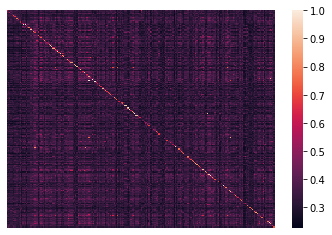

In [51]:
sb.heatmap(mean, xticklabels=False, yticklabels=False, cbar=True)

In [38]:
plt.savefig('NoCountry_simmatrix.png')

<Figure size 432x288 with 0 Axes>

In [2]:
import json

In [8]:
results = json.load(open('results.json', 'r'))

Round to 2 decimal points

In [41]:
for key in results.keys():
    result = results[key]
    for key2 in result:
        results[key][key2] = [round(recall,2) for recall in results[key][key2]]

In [44]:
movies = ['No.Country.for.Old.Men', 'Harry.Potter.and.the.Sorcerers.Stone', 'Shawshank.Redemption', 'The.Green.Mile', 'American.Psycho', 'One.Flew.Over.the.Cuckoo.Nest', 'Brokeback.Mountain', 'The.Road']
for key in movies:
    r1 = str(results[key]['recall/jaccard'][0]) + ' & ' +str(results[key]['recall/angular'][0]) + ' & ' + str(results[key]['recall/mean1'][0]) 
    r5 = str(results[key]['recall/jaccard'][1]) + ' & ' +str(results[key]['recall/angular'][1]) + ' & ' + str(results[key]['recall/mean1'][1]) 
    r10 = str(results[key]['recall/jaccard'][2]) + ' & ' +str(results[key]['recall/angular'][2]) + ' & ' + str(results[key]['recall/mean1'][2]) 

    print(f"{key}: {r1} & {r5} & {r10}")

No.Country.for.Old.Men: 0.83 & 0.79 & 0.83 & 0.86 & 0.87 & 0.88 & 0.89 & 0.88 & 0.91
Harry.Potter.and.the.Sorcerers.Stone: 0.65 & 0.59 & 0.7 & 0.74 & 0.7 & 0.79 & 0.79 & 0.76 & 0.83
Shawshank.Redemption: 0.7 & 0.59 & 0.73 & 0.77 & 0.77 & 0.8 & 0.8 & 0.8 & 0.82
The.Green.Mile: 0.55 & 0.54 & 0.6 & 0.67 & 0.66 & 0.73 & 0.73 & 0.68 & 0.78
American.Psycho: 0.71 & 0.7 & 0.76 & 0.8 & 0.78 & 0.85 & 0.83 & 0.82 & 0.87
One.Flew.Over.the.Cuckoo.Nest: 0.44 & 0.48 & 0.52 & 0.59 & 0.61 & 0.69 & 0.65 & 0.68 & 0.75
Brokeback.Mountain: 0.54 & 0.56 & 0.62 & 0.64 & 0.7 & 0.71 & 0.71 & 0.74 & 0.76
The.Road: 0.61 & 0.71 & 0.74 & 0.77 & 0.83 & 0.83 & 0.82 & 0.83 & 0.87


In [28]:
movies = ['No.Country.For.Old.Men', 'Harry.Potter.and.the.Sorcerers.Stone', 'Shawshank Redemption', 'The.Green.Mile', 'American.Psycho', 'One.Flew.Over.the.Cuckoo.Nest', 'Brokeback Mountain', 'The.Road']

In [29]:
movies

['No.Country.For.Old.Men',
 'Harry.Potter.and.the.Sorcerers.Stone',
 'Shawshank Redemption',
 'The.Green.Mile',
 'American.Psycho',
 'One.Flew.Over.the.Cuckoo.Nest',
 'Brokeback Mountain',
 'The.Road']

In [11]:
import numpy as np

In [26]:
len(movies)

11

In [47]:
score_types = list(results['American.Psycho'].keys())
movies = ['No.Country.for.Old.Men', 'Harry.Potter.and.the.Sorcerers.Stone', 'Shawshank.Redemption', 'The.Green.Mile', 'American.Psycho', 'One.Flew.Over.the.Cuckoo.Nest', 'Brokeback.Mountain', 'The.Road']
avgs = {}
for score in score_types[:3]:
    avg = np.array([0,0,0], dtype='float64')
    for movie in movies:
        print(results[movie][score])
        avg += np.array(results[movie][score])
    avg /= len(movies)
    avgs[score] = avg

[0.83, 0.86, 0.89]
[0.65, 0.74, 0.79]
[0.7, 0.77, 0.8]
[0.55, 0.67, 0.73]
[0.71, 0.8, 0.83]
[0.44, 0.59, 0.65]
[0.54, 0.64, 0.71]
[0.61, 0.77, 0.82]
[0.79, 0.87, 0.88]
[0.59, 0.7, 0.76]
[0.59, 0.77, 0.8]
[0.54, 0.66, 0.68]
[0.7, 0.78, 0.82]
[0.48, 0.61, 0.68]
[0.56, 0.7, 0.74]
[0.71, 0.83, 0.83]
[0.83, 0.88, 0.91]
[0.7, 0.79, 0.83]
[0.73, 0.8, 0.82]
[0.6, 0.73, 0.78]
[0.76, 0.85, 0.87]
[0.52, 0.69, 0.75]
[0.62, 0.71, 0.76]
[0.74, 0.83, 0.87]


In [48]:
avgs

{'recall/jaccard': array([0.62875, 0.73   , 0.7775 ]),
 'recall/angular': array([0.62   , 0.74   , 0.77375]),
 'recall/mean1': array([0.6875 , 0.785  , 0.82375])}

In [49]:
string = ""
for i in range(0,3):
    string += str(round(avgs['recall/jaccard'][i], 2)) + ' & ' + str(round(avgs['recall/angular'][i], 2)) + ' & ' + str(round(avgs['recall/mean1'][i], 2)) +' & '
print(string)

0.63 & 0.62 & 0.69 & 0.73 & 0.74 & 0.78 & 0.78 & 0.77 & 0.82 & 
